In [1]:
import rawgpy
import time
import json
import urllib.request
from nt import listdir
import os
import re
from os import path
import pandas as pd
import numpy as np
import nltk
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
# Performance metric
from sklearn.metrics import f1_score


pd.set_option('display.max_colwidth', 300)
meta = pd.read_csv("C:/Users/Matilde/Desktop/GitHub/datamin/genrePrediction/gameCleanShort.csv", sep = ',' , header = None)

meta.columns = ["id","name","description","genres"]
#meta.head()

In [2]:
games = pd.DataFrame(meta)
games.head()

,id,name,description,genres
0,18225,age of magic ccg,age magic onlin collect card game mmo twist master four power class build deck use unit card five distinct race extend collect upgrad defeat evil forc excit pve campaign take power oppon player dungeon show deck build play skill claim victori fellow player arena featur uniqu turn base gameplay e...,"['Strategy', 'RPG']"
1,76547,age of magic,age magic new mobil turn base fantasi rpg legion epic hero fight remnant ancient magic world welcom era mage warrior dragon form squad hero discov stori campaign mode defeat player unforgett pvp battl reach top arena tournament prove skill infam tomb horror grim lair easi enter hard leav aliv co...,"['RPG', 'Strategy']"
2,377145,age of myth genesis,age myth genesi strateg mobil game base ancient rome war becom citi lord battl expand make citi stronger never alon call alli unit fantasi race real time conquer fall love constant battl chat upgrad time chang everyon everyth dawn time god look earth eager eye age myth genesi lord battl crown ne...,"['RPG', 'Strategy']"
3,12470,age of mythology extended edition,age mythologyth classic real time strategi game transport player time hero battl monster legend god interven affair mortal use mytholog creatur like minotaur cyclop bolster armi strength call upon god assist flatten enemi town meteor scatter oppos troop lightn storm extend edit includ age mythol...,"['Strategy', 'Simulation']"
4,11794,age of rivals,deep civil build strategi fast pace card game know game spend hour build huge civil care balanc economi militari cultur defens prove greatest ruler ever age rival like minut version card mani path victori competit card draft game featur uniqu charact hundr card rang great pyramid war eleph sneak...,"['Strategy', 'Board Games', 'BoardGames']"


In [3]:
genres = [] 
genres1 = [] 
s1= ['']
# extract genres
for i in games['genres']: 
    a = list(i.replace("]",'').replace('[','').replace("'",'').replace(' ','').split(","))
    if a == s1:
        genres.append(' ') 
    else:
        genres.append(a)
        genres1.append(a)

# add to 'movies' dataframe  
games['genre_new'] = genres
games.shape

(41806, 5)

In [4]:
games_new =  games[~(games['genre_new'] == ' ')]
games_new.head(1000)

,id,name,description,genres,genre_new
0,18225,age of magic ccg,age magic onlin collect card game mmo twist master four power class build deck use unit card five distinct race extend collect upgrad defeat evil forc excit pve campaign take power oppon player dungeon show deck build play skill claim victori fellow player arena featur uniqu turn base gameplay e...,"['Strategy', 'RPG']","[Strategy, RPG]"
1,76547,age of magic,age magic new mobil turn base fantasi rpg legion epic hero fight remnant ancient magic world welcom era mage warrior dragon form squad hero discov stori campaign mode defeat player unforgett pvp battl reach top arena tournament prove skill infam tomb horror grim lair easi enter hard leav aliv co...,"['RPG', 'Strategy']","[RPG, Strategy]"
2,377145,age of myth genesis,age myth genesi strateg mobil game base ancient rome war becom citi lord battl expand make citi stronger never alon call alli unit fantasi race real time conquer fall love constant battl chat upgrad time chang everyon everyth dawn time god look earth eager eye age myth genesi lord battl crown ne...,"['RPG', 'Strategy']","[RPG, Strategy]"
3,12470,age of mythology extended edition,age mythologyth classic real time strategi game transport player time hero battl monster legend god interven affair mortal use mytholog creatur like minotaur cyclop bolster armi strength call upon god assist flatten enemi town meteor scatter oppos troop lightn storm extend edit includ age mythol...,"['Strategy', 'Simulation']","[Strategy, Simulation]"
4,11794,age of rivals,deep civil build strategi fast pace card game know game spend hour build huge civil care balanc economi militari cultur defens prove greatest ruler ever age rival like minut version card mani path victori competit card draft game featur uniqu charact hundr card rang great pyramid war eleph sneak...,"['Strategy', 'Board Games', 'BoardGames']","[Strategy, BoardGames, BoardGames]"
...,...,...,...,...,...
995,367423,battlemonleague,real time team match pvp destroy block build path hunt giant monster cooper play captur enemi tower win gain trophi reach higher level battlemon leagu multiplay action game player overpow enemi summon monster fight hand hand combat snipe cooper key strategi combin differ monster card build perfe...,"['Action', 'Strategy']","[Action, Strategy]"
996,384480,battlenetwork 2d to 3d,build proper represent team jam due timezon differ limit avail cst friday spent hour jam oct cst oct cst pleas consid check full submiss,"['Action', 'Strategy']","[Action, Strategy]"
997,342669,battleon necroboi,control wasd amp arrow key restart,['Fighting'],[Fighting]
998,13027,battlepaths,battlepath loot centric addict rpg featur neat monster hack excel loot system huge varieti charact develop learn skill use powerful potion hunt chao overlord battl begin babatula first three big realm explor battlepath offer sophist drop system generat countless differ item along uniqu item char...,['RPG'],[RPG]


In [5]:
games_new.shape, games.shape

((41806, 5), (41806, 5))

In [6]:
all_genres = sum(genres1,[])
print(len(set(all_genres)))

12


In [7]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
print(list(all_genres.keys()))

['Strategy', 'RPG', 'Simulation', 'BoardGames', 'Action', 'Adventure', 'Shooter', 'Puzzle', 'Sports', 'Racing', 'Fighting', 'Educational']


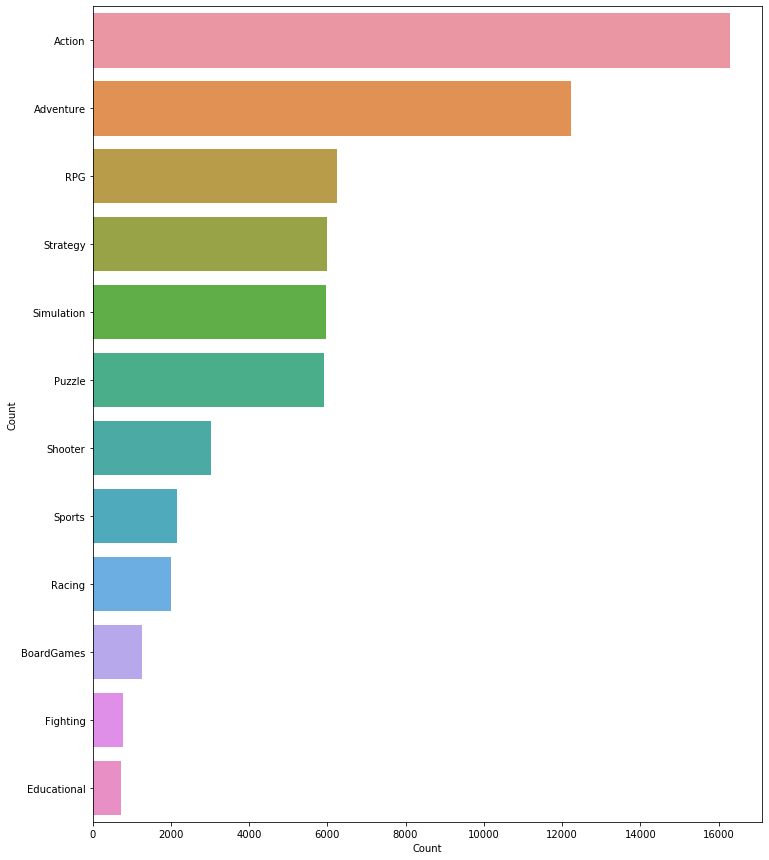

In [8]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [9]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(games_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(games_new['genre_new'])

In [0]:

#f = pd.DataFrame(games_new)
#i=0
#for genre in list(all_genres.keys()):
#    genreli = y[:,i]
#    f[genre] = genreli 
#    i=i+1
    
#print(f)


In [10]:
print(y)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(games_new['description'], y, test_size=0.2, random_state=9)

In [12]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [13]:
print(xtrain[1])

age magic new mobil turn base fantasi rpg legion epic hero fight remnant ancient magic world welcom era mage warrior dragon form squad hero discov stori campaign mode defeat player unforgett pvp battl reach top arena tournament prove skill infam tomb horror grim lair easi enter hard leav aliv collect level legendari hero fight fast pace battl grand arena take pick dozen charact among kobold elv demon druid changel dragonkin archn dark descend upon ruin remnant world float void night anoth light beam sky fade devour unstopp demon legion yet still hope dragon propheci foretel true mage enter dark tower determin fate univers might chosen one age magic gameplay stori campaign explor vast age magic world pierc power light dark meet legendari hero fight epic battl terrifi enemi follow stori roland true mage quest dark tower step dark meet changel assassin sharazar stop noth get came pvp build ultim parti hero challeng player pvp arena daili prove hour tournament everi week fight way top win 

In [14]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)
print(xtrain_tfidf[1])

(0, 9246)	0.17614837427073193
  (0, 5844)	0.0878833328437008
  (0, 3401)	0.2026099211762428
  (0, 3441)	0.11645402118655378
  (0, 5938)	0.251217017138399
  (0, 2191)	0.18950326399715717
  (0, 8540)	0.12709498766301666
  (0, 7304)	0.1780869632353911
  (0, 2408)	0.2009645530452638
  (0, 870)	0.21246386136946172
  (0, 7709)	0.13836585595617806
  (0, 4469)	0.13767677579196416
  (0, 1373)	0.10537807622389894
  (0, 5841)	0.14398756392927037
  (0, 9305)	0.17753588374478282
  (0, 219)	0.11047694347066216
  (0, 2903)	0.15017180689951584
  (0, 3041)	0.20613251698761362
  (0, 6542)	0.0714513539606688
  (0, 8924)	0.13974932749781696
  (0, 8481)	0.23653885865286942
  (0, 7771)	0.296173051091608
  (0, 6108)	0.11582530090951593
  (0, 4090)	0.15088576813157825
  (0, 8946)	0.14044343979569973
  (0, 7699)	0.19249714035683535
  (0, 1653)	0.20969584590772278
  (0, 6030)	0.1831799632959924
  (0, 3502)	0.10697894607652754
  (0, 5612)	0.17536549751233893
  (0, 7724)	0.1854712223044702
  (0, 438)	0.1320372555

In [15]:
print(xtrain_tfidf)

(0, 2274)	0.05007029144453772
  (0, 3502)	0.05444701991437905
  (0, 5567)	0.0892524098014486
  (0, 7468)	0.12188028655406662
  (0, 261)	0.0915289693598694
  (0, 1757)	0.15641669799952837
  (0, 70)	0.0805403842181172
  (0, 8730)	0.05837327932327627
  (0, 7141)	0.12072117764800422
  (0, 2958)	0.08903456616379733
  (0, 4144)	0.07539005691546843
  (0, 1648)	0.08593988636740238
  (0, 2965)	0.0538779573006851
  (0, 9437)	0.1818442489406068
  (0, 683)	0.057664936249252965
  (0, 3101)	0.17064569866064483
  (0, 1598)	0.05808940535637389
  (0, 6826)	0.3023637583451241
  (0, 8407)	0.12176118160626341
  (0, 2005)	0.15467979121893258
  (0, 3815)	0.11941658371854874
  (0, 4982)	0.04639589107365259
  (0, 1690)	0.09512497939347717
  (0, 5993)	0.07020859350128357
  (0, 4278)	0.10177036552297786
  :	:
  (33443, 3089)	0.01106219195337658
  (33443, 8754)	0.013223692864203974
  (33443, 1355)	0.028428567128541034
  (33443, 8742)	0.06473411549484552
  (33443, 7052)	0.12162368172050432
  (33443, 2311)	0.01355

In [16]:
lr = LogisticRegression(max_iter=100000000)
clf = OneVsRestClassifier(lr)

In [17]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None,
                                                 max_iter=100000000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [18]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [19]:
y_pred[3]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(yval, y_pred)

0.3249222674001435

In [21]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('Adventure',)

In [22]:
f1_score(yval, y_pred, average="micro")

0.592422960123463

In [24]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [25]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [26]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.6527887501975036

In [0]:
#########################

In [27]:

def infer_tags(q):
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [30]:

for i in range(20): 
  k = xval.sample(1).index[0] 
  print("game: ", games_new['name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",games_new['genre_new'][k], "\n")

game:  the last shot 
Predicted genre:  [('Action',)]
Actual genre:  ['Action', 'Shooter'] 

game:  gym days 
Predicted genre:  [('Adventure',)]
Actual genre:  ['Adventure'] 

game:  cafeteria nipponica 
Predicted genre:  [('Simulation',)]
Actual genre:  ['Strategy', 'Simulation'] 

game:  russian racing 
Predicted genre:  [('Racing',)]
Actual genre:  ['Racing'] 

game:  gargolite 
Predicted genre:  [()]
Actual genre:  ['Action'] 

game:  barbie as the island princess 
Predicted genre:  [('Adventure',)]
Actual genre:  ['Adventure'] 

game:  shred downhill mountain biking 
Predicted genre:  [('Action',)]
Actual genre:  ['Action', 'Sports', 'Racing'] 

game:  matthew borg game prototypes 
Predicted genre:  [()]
Actual genre:  ['Action', 'Adventure'] 

game:  james pattersons womens murder club twice in a blue moon 
Predicted genre:  [()]
Actual genre:  ['Puzzle'] 

game:  escape the humans 
Predicted genre:  [('Action',)]
Actual genre:  ['Action', 'Puzzle'] 

game:  crystal quest classic

In [0]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

In [0]:
# get the first vector out (for the first document)
first_vector_tfidfvectorizer=xtrain_tfidf[1]

# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head(20)


In [0]:
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
for category in categories:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(yval, y_pred)